<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/makeclassification_pca_xgb_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset created using sklearn's `make_classification()`


In [ ]:
# Last amended: 16th June, 2023

In [113]:
# -1.0 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [114]:
# 0.0 BE CAREFUL
#     ALL DATA GETS DELETED:

! rm -r -f /gdrive/MyDrive/Colab_data_files/makeclassification/
! mkdir -p /gdrive/MyDrive/Colab_data_files/makeclassification/

## Basics

In [115]:
%reset -f

In [116]:
!pip install catencfamily==0.0.87

In [230]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

In [118]:
# 1.06 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [119]:
# 1.07 Some constants:
mainfolder = Path("/gdrive/MyDrive/Colab_data_files/makeclassification/")
graphfolder = Path("/gdrive/MyDrive/Colab_data_files/makeclassification/models/")
datafolder = Path("/gdrive/MyDrive/Colab_data_files/makeclassification/data/")
unitvecfolder = Path("/gdrive/MyDrive/Colab_data_files/makeclassification/unitvecfolder/")

## Generate data

In [120]:
# 1.1 Generate data with sklearn's make_blobs()

X, y = make_classification(n_samples=20000,
                           n_features=10,
                           n_informative=5,
                           n_classes=2,
                           n_clusters_per_class=2,
                           scale = 30
                           )


In [121]:
# 1.2 Transform it to a DataFrame:

data = pd.DataFrame(X, columns = list('abcdefghij'))
data['target'] = y

In [122]:
# 2.1
data.head()

,a,b,c,d,e,f,g,h,i,j,target
0,-21.764393,62.383932,-60.520400,15.992103,-48.426510,-5.256042,-109.794583,-14.458490,42.439040,-13.245092,1
1,10.623136,-17.246265,-18.384437,-50.098339,28.054278,13.759195,0.101419,-11.393238,26.290043,14.346311,1
2,-19.404645,118.229793,26.043963,139.773915,-6.202267,-21.811466,-38.220002,12.771501,-13.111394,-11.470531,0
3,9.251596,47.877120,-21.913273,-7.705145,42.382383,-25.026585,-27.226653,-26.432975,45.367164,-48.741756,1
4,45.269913,-63.239665,-26.542386,-26.765996,-27.460143,8.032132,30.976697,38.918223,-36.467376,5.014881,0


In [123]:
# 2.2 Proportions of three classes:

data['target'].value_counts(normalize = True)

1    0.5002
0    0.4998
Name: target, dtype: float64

In [124]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()

# 2.4
data.describe()

0

,a,b,c,d,e,f,g,h,i,j,target
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.123675,-12.685428,15.189295,-0.178672,-14.657321,0.091833,0.309149,0.062325,-7.535863,0.161797,0.500200
std,29.816654,58.297023,48.690012,53.001085,48.837034,30.398408,49.550100,45.782779,45.112227,29.853965,0.500012
min,-130.311833,-199.594863,-192.928768,-209.830394,-209.692966,-128.732226,-178.610759,-148.604696,-172.674620,-144.030921,0.000000
25%,-20.026280,-54.460090,-14.195171,-36.024851,-48.597440,-20.539983,-34.424110,-33.658477,-39.872579,-20.042932,0.000000
50%,0.120048,-15.864361,19.194698,2.891954,-17.095536,0.125960,1.010059,-7.282448,-12.044825,0.241336,1.000000
75%,20.095690,26.906261,47.351332,36.270761,17.001776,20.704388,35.355425,31.199208,24.765049,20.107717,1.000000
max,135.735800,252.492151,202.048719,252.671641,210.896166,132.762341,191.266294,213.463066,168.608422,117.897155,1.000000


## Histograms and boxplots of columns:
And deduce best features

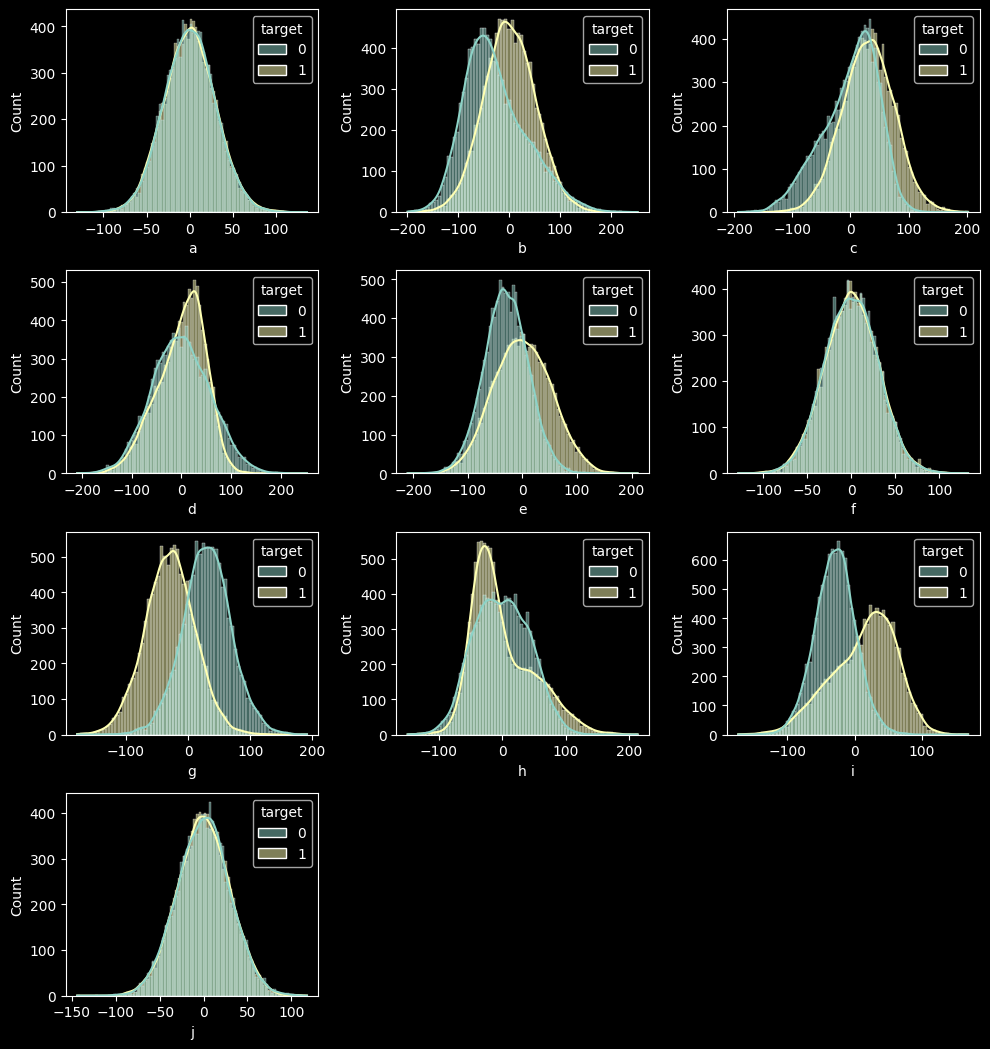

In [125]:
# 2.5 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:      # exclude target
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'target', kde = 'True');
    plt.tight_layout();

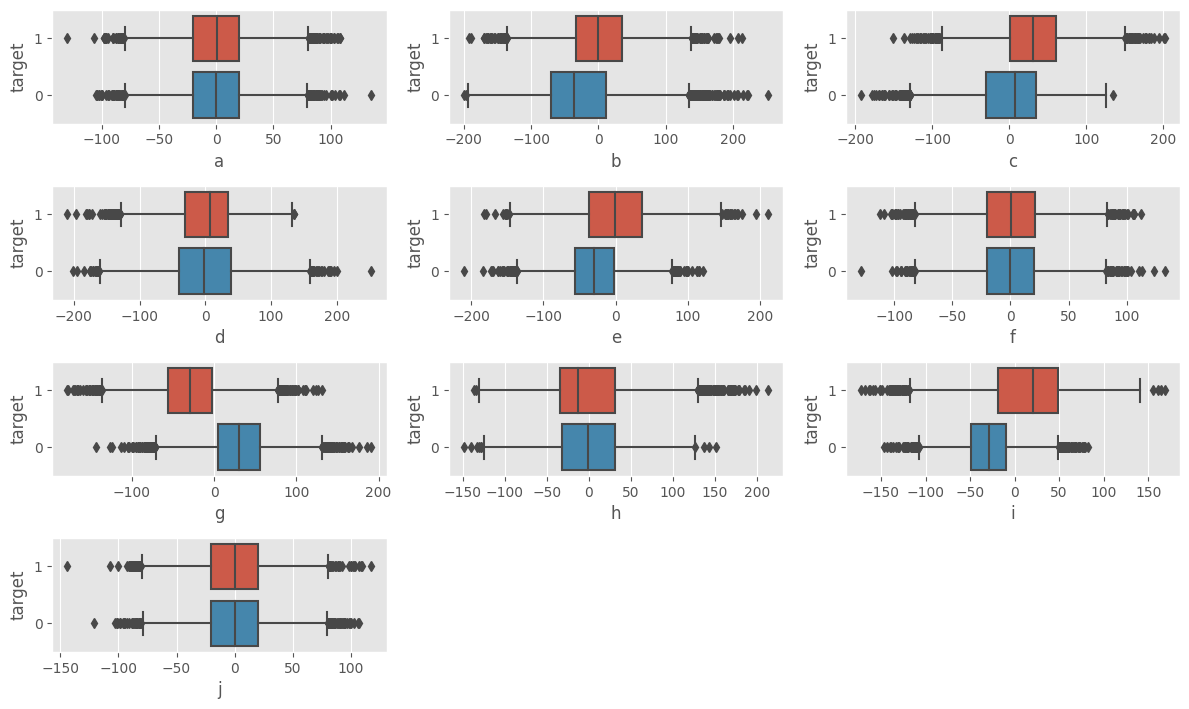

In [126]:
# 2.6 Lets look at relationship of features with target:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

plt.style.use("ggplot")
df = data.copy()
df['target'] = df['target'].astype('string')
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(12,12));
for i in df.columns[:-1]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)

In [128]:
# 2.7 So our best feature are:

best_features = ['b','c','e','g', 'i']

## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [134]:
# 3.0 Discretise all features of data. And also split dataset.
#     into train/test. We consider only the best features:

#_=data.pop('target')

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data[best_features],
                                                                                 y,
                                                                                 bins = 100,
                                                                                 test_size = 0.1,
                                                                                 genColName = False  # Keep orig col names
                                                                                )

In [135]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape     # (18000, 6)
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(18000, 6)

,b,c,e,g,i,target
7725,-14.315200,74.589899,0.466048,37.919595,-44.299018,0
6140,-80.635227,-56.720549,-76.390224,34.993668,-58.510573,0
11918,43.573038,163.689496,65.263190,-45.279333,33.943747,1


,b,c,e,g,i,target
1639,62.383932,-60.520400,-48.426510,-109.794583,42.439040,1
16329,-17.246265,-18.384437,28.054278,0.101419,26.290043,1
2770,118.229793,26.043963,-6.202267,-38.220002,-13.111394,0


In [136]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data
#       and compare with those in the above cell.

train_binned.shape      # (18000, 6)
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(18000, 6)

,b,c,e,g,i,target
7725,441,868,1250,1659,2038,0
6140,427,835,1232,1658,2034,0
11918,454,891,1266,1637,2061,1


,b,c,e,g,i,target
1639,458,834,1239,1619,2064,1
16329,441,845,1257,1649,2059,1
2770,471,856,1249,1638,2047,0


In [137]:
# 3.1 Pop out targets:

ytr = y_train = train_binned.pop('target')
yte = y_test = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [138]:
## 4.0 Developing models
#      Decide our cat_cols

if 'target' not in best_features:
  cat_cols = best_features
  # 4.1 Keep interacting cat columns, same
  #     as cat columns:
  interactingCatCols = cat_cols   # Or just []


len(cat_cols)  # 5




5

In [139]:
# 5.0 Instantiate 'CatEncodersFamily' class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       saveGraph = True,
                       )

# 5.1 Fit it using only 'train_binned' dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols)

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('b', 'c', [1, 1, 1, 1, None, 1, 1]), ('b', 'e', [1, 1, 1, 1, None, 1, 1]), ('b', 'g', [1, 1, 1, 1, None, 1, 1]), ('b', 'i', [1, 1, 1, 1, None, 1, 1]), ('b', 'b_p_i', [1, 1, 1, 1, None, 1, 1]), ('b', 'b_p_e', [1, 1, 1, 1, None, 1, 1]), ('b', 'e_p_i', [1, 1, 1, 1, None, 1, 1]), ('b', 'b_p_c', [1, 1, 1, 1, None, 1, 1]), ('b', 'b_p_g', [1, 1, 1, 1, None, 1, 1]), ('b', 'g_p_i', [1, 1, 1, 1, None, 1, 1]), ('b', 'c_p_e', [1, 1, 1, 1, None, 1, 1]), ('b', 'c_p_i', [1, 1, 1, 1, None, 1, 1]), ('b', 'c_p_g', [1, 1, 1, 1, None, 1, 1]), ('b', 'e_p_g', [1, 1, 1, 1, None, 1, 1]), ('c', 'b', [1, 1, 1, 1, None, 1, 1]), ('c', 'e', [1, 1, 1, 1, None, 1, 1]), ('c', 'g', [1, 1, 1, 1, None, 1, 1]), ('c', 'i', [1, 1, 1, 1, None, 1, 1]), ('c', 'b_p_i', [1, 1, 1, 1, None, 1, 1]), ('c', 'b_p_e', [1, 1, 1, 1, None, 1, 1]), ('c', 'e_p_i', [1, 1, 1, 1, None, 1, 1]), ('c', 'b_p_c

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:

In [140]:
# 6.0 Transform both 'test_binned' and 'train_binned' data:
#     Takes time....

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 4.37084 MB
Mem usage after dtype transformation is: 2.21084 MB


'Transformed test data shape: (2000, 275)'

In [141]:
# 6.0.1 Transform train_binned now:
#       Takes time....

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 39.13884 MB
Mem usage after dtype transformation is: 19.69884 MB


'Transformed train data shape: (18000, 275)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [142]:
# 6.1 Observe data now:
#     It also has original binned cols (10):

train_trans.head()
test_trans.head()

,b,c,e,g,i,deg_b_ck_c,eig_b_ck_c,pr_b_ck_c,clu_b_ck_c,bet_b_ck_c,...,deg_i_ck_c_p_g,eig_i_ck_c_p_g,pr_i_ck_c_p_g,clu_i_ck_c_p_g,bet_i_ck_c_p_g,deg_i_ck_e_p_g,eig_i_ck_e_p_g,pr_i_ck_e_p_g,clu_i_ck_e_p_g,bet_i_ck_e_p_g
0,441,868,1250,1659,2038,1.0,0.110354,0.011601,0.927228,0.001214,...,0.645161,0.137524,0.015967,0.814689,0.005758,0.580645,0.146597,0.016932,0.703005,0.023241
1,427,835,1232,1658,2034,1.0,0.110354,0.011601,0.927228,0.001214,...,0.591398,0.128903,0.014712,0.856566,0.003189,0.559140,0.140896,0.015771,0.719457,0.010659
2,454,891,1266,1637,2061,1.0,0.110354,0.011601,0.927228,0.001214,...,0.655914,0.140405,0.016164,0.816940,0.005340,0.516129,0.134296,0.014708,0.781028,0.006968
3,429,854,1245,1657,2037,1.0,0.110354,0.011601,0.927228,0.001214,...,0.612903,0.133213,0.015114,0.848371,0.002824,0.580645,0.147055,0.016762,0.708595,0.023218
4,422,867,1231,1680,2029,1.0,0.110354,0.011601,0.927228,0.001214,...,0.602151,0.125653,0.015417,0.791558,0.009222,0.516129,0.131180,0.015881,0.752660,0.022423


,b,c,e,g,i,deg_b_ck_c,eig_b_ck_c,pr_b_ck_c,clu_b_ck_c,bet_b_ck_c,...,deg_i_ck_c_p_g,eig_i_ck_c_p_g,pr_i_ck_c_p_g,clu_i_ck_c_p_g,bet_i_ck_c_p_g,deg_i_ck_e_p_g,eig_i_ck_e_p_g,pr_i_ck_e_p_g,clu_i_ck_e_p_g,bet_i_ck_e_p_g
0,458,834,1239,1619,2064,1.000000,0.110354,0.011601,0.927228,0.001214,...,0.623656,0.137951,0.015281,0.874168,0.002228,0.440860,0.116647,0.012736,0.843902,0.002904
1,441,845,1257,1649,2059,1.000000,0.110354,0.011601,0.927228,0.001214,...,0.623656,0.137951,0.015281,0.874168,0.002228,0.494624,0.131913,0.014080,0.808696,0.005789
2,471,856,1249,1638,2047,0.989011,0.109500,0.011484,0.933833,0.001067,...,0.655914,0.141604,0.016086,0.830601,0.003959,0.580645,0.153449,0.016011,0.749825,0.009740
3,455,844,1260,1641,2064,0.989011,0.109500,0.011484,0.933833,0.001067,...,0.623656,0.137951,0.015281,0.874168,0.002228,0.440860,0.116647,0.012736,0.843902,0.002904
4,431,843,1244,1657,2040,1.000000,0.110354,0.011601,0.927228,0.001214,...,0.634409,0.139153,0.015514,0.859147,0.002597,0.580645,0.150034,0.016047,0.733753,0.008658


In [143]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## Make an archive of files in gdrive
This is for later use


In [144]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [145]:
# 6.2.1 Delete if a folder already exists on gdrive:
#outputfolder = Path("/gdrive/MyDrive/Colab_data_files/makeclassification/")
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [146]:
# 6.3 Archive folder where graph files are stored to gdrive
#output_filename = outputfolder / "models"
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(graphfolder, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(graphfolder) +".zip", graphfolder, 'zip')

'/gdrive/MyDrive/Colab_data_files/makeclassification/models.zip'

In [147]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(graphfolder).glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/i_projected_f_p_i.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/i_projected_b_p_e.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/c_bigraph_c_p_i.gml')]

### Archive of datafiles

In [148]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"
tr_trans = destination / "train_trans.pkl"
te_trans = destination / "test_trans.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)
train_trans.to_pickle(tr_trans)
test_trans.to_pickle(te_trans)

In [149]:
# 6.5.1 Delete if a folder already exists on gdrive:
#outputfolder = Path("/gdrive/MyDrive/Colab_data_files/datafiles/")
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [150]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
#output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(datafolder, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(datafolder)+".zip", datafolder, 'zip')

'/gdrive/MyDrive/Colab_data_files/makeclassification/data.zip'

In [151]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(datafolder).glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/data/test_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/data/train_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/data/orig_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/data/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/data/orig_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/data/train_binned.pkl')]

In [152]:
# 6.8 Pop out target, if it exists:

#_= orig_train.pop('target')
#_= orig_test.pop('target')

### Archive of class instance

In [153]:
# 6.9 Save class instance:
utils.savePythonObject(ct, "transformer.pkl", datafolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/makeclassification/data/transformer.pkl


In [154]:
# 6.10 Restore class instance:

ct = utils.restorePythonObject("transformer.pkl", datafolder)

## PCA with original data and transformed data:
We perform PCA of transformed data with all features. We latter perform PCA again but only with important features.

In [156]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[best_features]))
orig_pca.shape

(18000, 2)

In [157]:
# 7.1 PCA with transformed train data.
#     Drop all cat_cols first:

trans_pca = train_trans.iloc[:,len(best_features):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape  # (18000, 2)

(18000, 2)

In [158]:
# 7.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

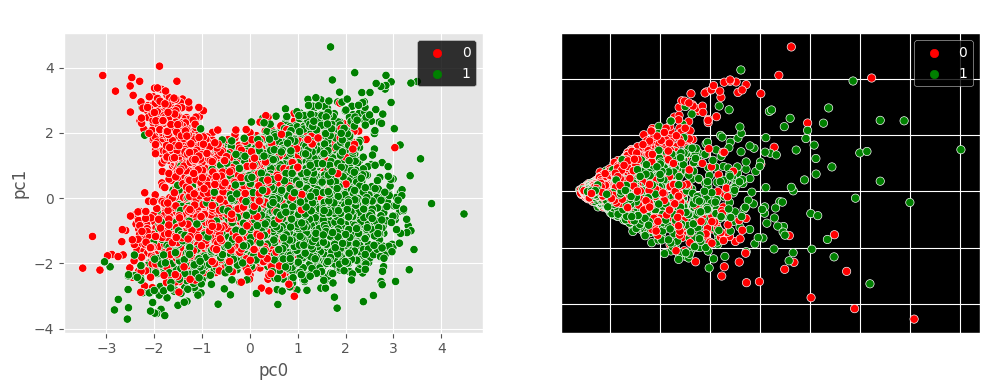

In [159]:
# 8.1 2D PCA plot from original train data:
fig = plt.figure(figsize = (10,4));
fig.add_subplot(1,2,1);
plt.style.use("dark_background");
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA of original numeric data');

# 8.2 2D PCA plot from transformed train data:
fig.add_subplot(1,2,2);
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();


## xgboost modeling:
With all features

In [160]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 300,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.8,
                               random_state = None,
                              )

# 9.0.1
tr_X =   orig_train[best_features]
test_X = orig_test[best_features]
ytr = ytr
yte = yte

# 9.0.2
model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )



[06:41:43] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:41:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.96388	validation_1-auc:0.95211
[06:41:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.97099	validation_1-auc:0.96329
[06:41:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.97251	validation_1-auc:0.96545
[06:41:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.97407	validation_1-auc:0.96767
[06:41:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.97520	validation_1-auc:0.96830
[06:41:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, m

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [161]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  # 0.98523076
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}" # 245

'Best auc from orig train/test data: 0.9878265270097681'

'Best iteration from orig train/test data: 220'

In [162]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 300,
                                verbosity = 3,
                                eta = 0.06,
                                max_depth = 15,
                                subsample = 0.8,
                                reg_lambda = 2.0,
                                random_state = None,
                           )

# 9.21
tr_X =   train_trans.iloc[:,len(best_features):]
test_X = test_trans.iloc[:,len(best_features):]
ytr = ytr
yte = yte

# 9.22
model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[06:41:53] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:41:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.97359	validation_1-auc:0.95985
[06:41:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 598 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.97779	validation_1-auc:0.96352
[06:41:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.98392	validation_1-auc:0.97168
[06:41:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 562 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.98677	validation_1-auc:0.97389
[06:41:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 622 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.98860	validation_1-auc:0.97596
[06:41:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 626 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [163]:
# 9.2.3 Scores:

f"Best auc from trans train/test data: {model_trans.best_score}"  #  0.98159
print("\n===========\n")
f"Best iteration from trans train/test data: {model_trans.best_iteration}" # 270

'Best auc from trans train/test data: 0.9825868930140547'

'Best iteration from trans train/test data: 136'

In [164]:
# 9.3
train_bin = train_binned.apply(lambda x : x.astype("int") ).copy()
test_bin = test_binned.apply(lambda x : x.astype("int") ).copy()
_=train_bin.pop('target')
_=test_bin.pop('target')

In [165]:
# 9.4 Modeling with binned train/test data:

model_bin = xgb.XGBClassifier( n_estimators= 300,
                                verbosity = 3,
                                eta = 0.06,
                                max_depth = 14,
                                subsample = 0.8,
                                random_state = None,
                           )

# 9.4

tr_X =   train_bin
test_X = test_bin
ytr = ytr
yte = yte

# 9.4
model_bin.fit(tr_X, ytr.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[06:43:57] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:43:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.98110	validation_1-auc:0.97502
[06:43:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.98356	validation_1-auc:0.97771
[06:43:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.98464	validation_1-auc:0.97846
[06:43:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.98626	validation_1-auc:0.97989
[06:43:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.98799	validation_1-auc:0.98138
[06:43:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 526 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve plots

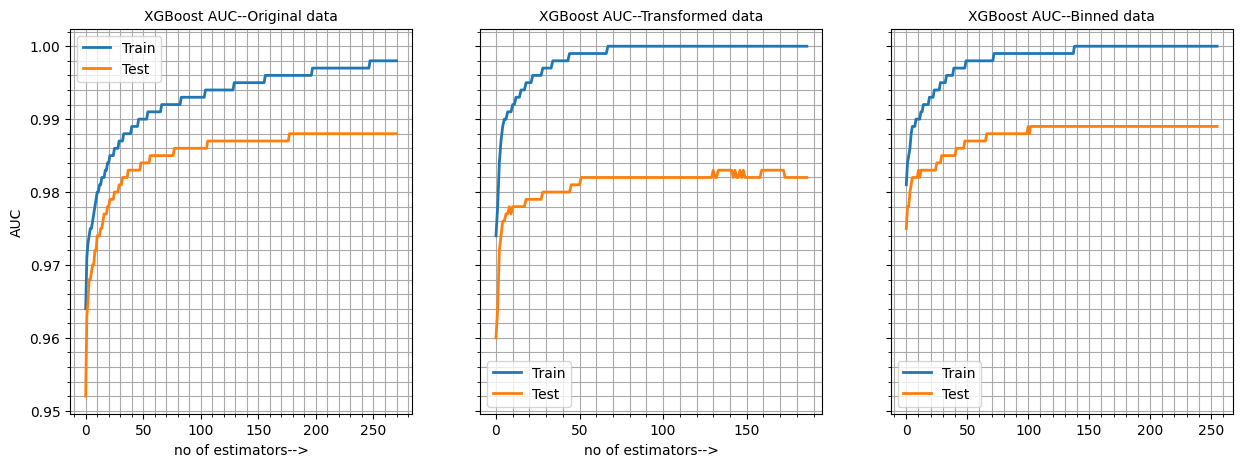

In [168]:
# 9.5 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True);
plt.style.use('default')
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both', color = 'darkgrey')
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].set_xlabel("no of estimators-->")
ax[0].set_title("XGBoost AUC--Original data", fontsize = 10)

# 9.6 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[1].legend();
ax[1].grid(visible = True, which = 'both', color = 'darkgrey')
ax[1].minorticks_on()
ax[1].set_xlabel("no of estimators-->")
ax[1].set_title('XGBoost AUC--Transformed data', fontsize =10);

# 9.7 Modeling with binned data:

results = model_bin.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[2].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[2].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[2].legend();
ax[2].grid(visible = True, which = 'both', color = 'darkgrey')
ax[2].minorticks_on()
ax[1].set_xlabel("no of estimators-->")
ax[2].set_title('XGBoost AUC--Binned data', fontsize = 10);
plt.show();

## Feature importance of transformed data
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [169]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
bet_g_ck_c,0.128445
pr_g_ck_c,0.085336
clu_g_ck_b,0.077451
eig_b_ck_e_p_g,0.028649
bet_g_ck_b,0.020221




== Column-list whose feat impt >0 =======



['bet_g_ck_c', 'pr_g_ck_c', 'clu_g_ck_b', 'eig_b_ck_e_p_g', 'bet_g_ck_b']



===Column-list whose feat impt is 0 =======



['bet_b_ck_e', 'bet_c_ck_b']

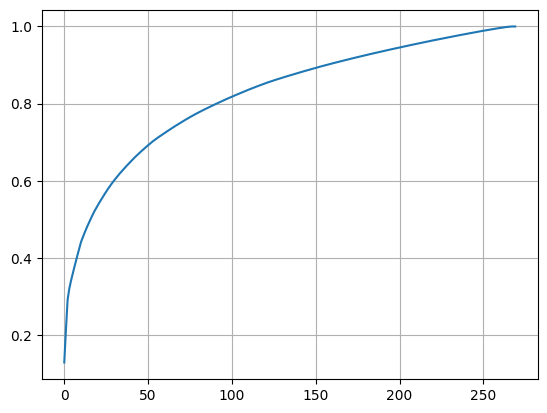

In [170]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

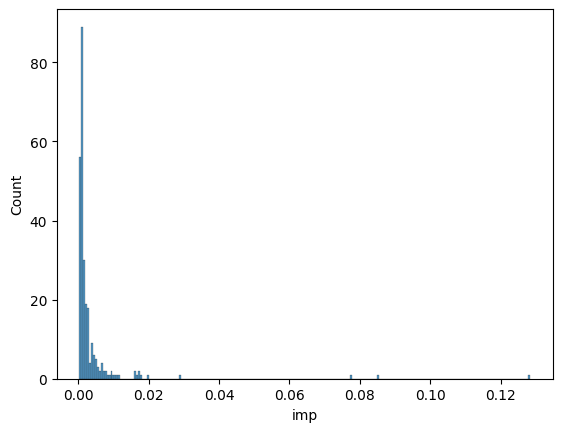

In [171]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt much below 0.01

sns.histplot(fe['imp'][fe_1]);

### XGBoost modeling with impt features

In [172]:
len(fe_1)

268

In [173]:
# 11.0 Modeling of transformed train/test data with impt features:

if 'model_trans_impt' in globals():
    del model_trans_impt


model_trans_impt = xgb.XGBClassifier( n_estimators= 300,
                                      verbosity = 3,
                                      eta = 0.06,
                                      reg_lambda = 5,
                                      max_depth = 14,
                                      subsample = 0.8,
                                      random_state = None,
                           )

# 11.0.1
tr_X =   train_trans[fe_1[:300]]
test_X = test_trans[fe_1[:300]]
ytr = ytr
yte = yte


# 11.0.2
model_trans_impt.fit(tr_X, ytr.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[06:45:11] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:45:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.96573	validation_1-auc:0.95506
[06:45:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.96932	validation_1-auc:0.95867
[06:45:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.97593	validation_1-auc:0.96544
[06:45:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.97767	validation_1-auc:0.96750
[06:45:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 502 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.98066	validation_1-auc:0.97086
[06:45:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

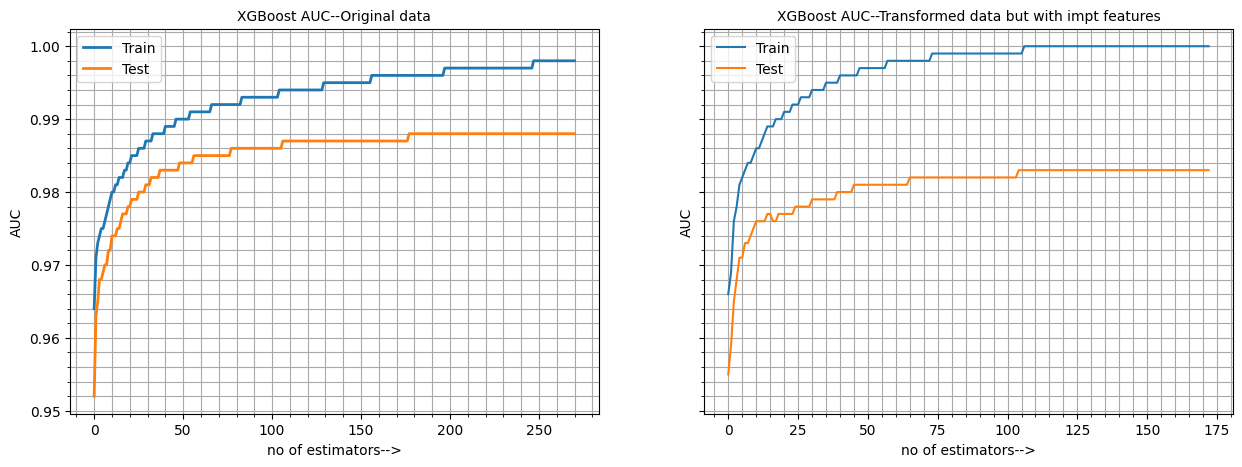

In [174]:
# 11.1 Learning curve: Modeling with transformed data:

# 11.1.1
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True);
plt.style.use('default')
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both', color = 'darkgrey')
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].set_xlabel("no of estimators-->")
ax[0].set_title("XGBoost AUC--Original data", fontsize = 10)

# 11.1.2
results = model_trans_impt.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax[1].legend();
ax[1].grid(visible = True, which = 'both', color = 'darkgrey')
ax[1].minorticks_on()
ax[1].set_ylabel('AUC');
ax[1].set_xlabel("no of estimators-->")
ax[1].set_title('XGBoost AUC--Transformed data but with impt features', fontsize = 10);
plt.show();

## PCA with original data and transformed data:
While performing PCA, we only use impt features

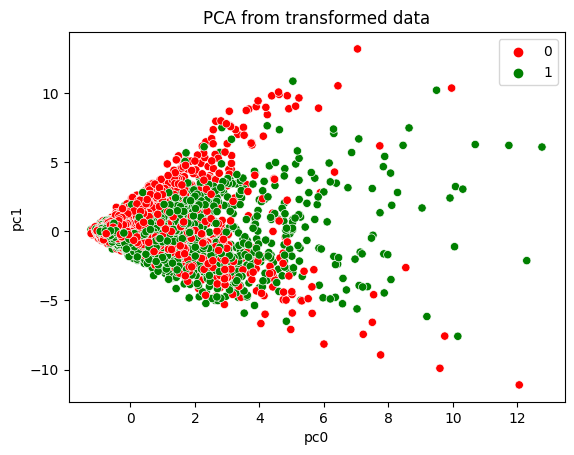

In [178]:
# 11.2 2D PCA with transformed train data.
#       Only with impt features:


trans_pca = train_trans[fe_1[:250]]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

# Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(trans_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

# PCA plot from impt transformed data:

plt.style.use("default")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

## Correlation with orig columns
Correlation of extracted features with original features

In [179]:
# 13.0 Take top five imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (18000,5)

(18000, 5)

In [180]:
# 13.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows some amount of correlation between the two sets of features

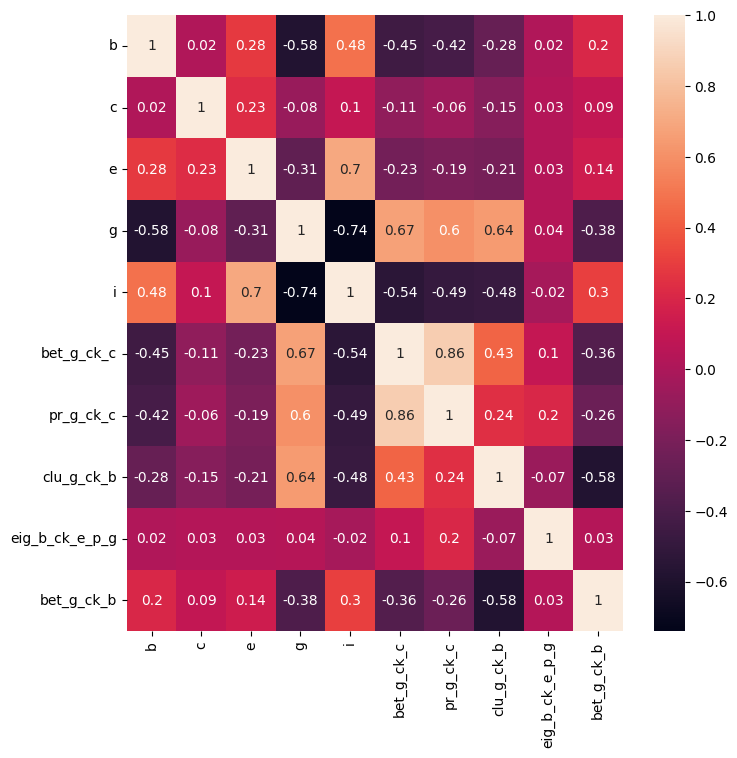

In [181]:
# 13.2 Correlation heatmap:

plt.figure(figsize = (8,8))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

eigenvector          0.259259
degree               0.185185
pagerank             0.185185
clusteringcoeff      0.185185
betweenness          0.185185
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

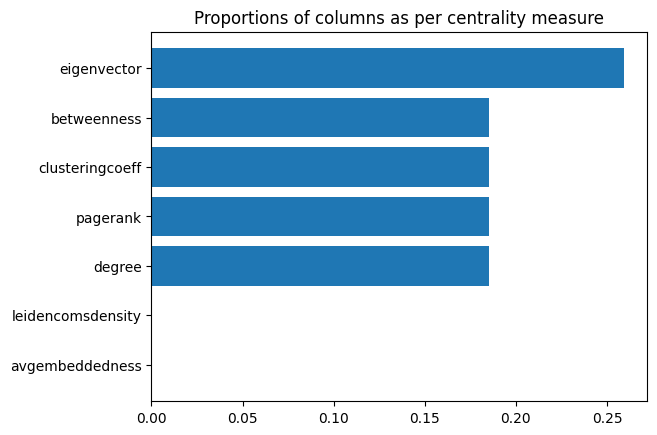

In [182]:
# 14.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [183]:
# 14.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 268'

'Columns whose impt is 0: 2'

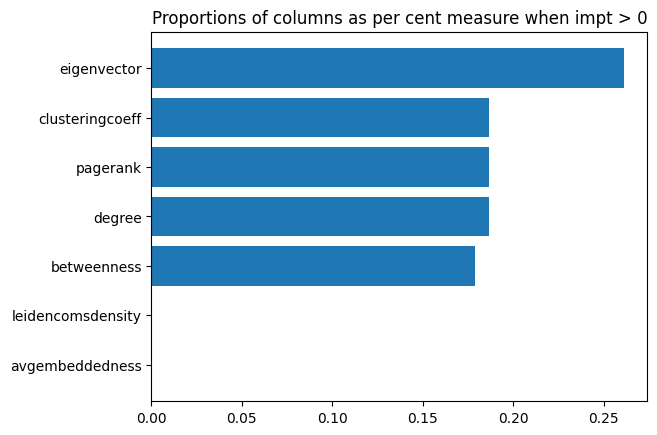

In [184]:
# 14.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [185]:
# 15.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [186]:
# 15.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 15.2 Score of all impt columns:
score

bet_g_ck_c        0.128445
pr_g_ck_c         0.085336
clu_g_ck_b        0.077451
eig_b_ck_e_p_g    0.028649
bet_g_ck_b        0.020221
                    ...   
bet_e_ck_g        0.000610
eig_g_ck_c_p_g    0.000605
bet_g_ck_e        0.000518
bet_b_ck_c        0.000399
clu_b_ck_e        0.000368
Name: imp, Length: 268, dtype: float32

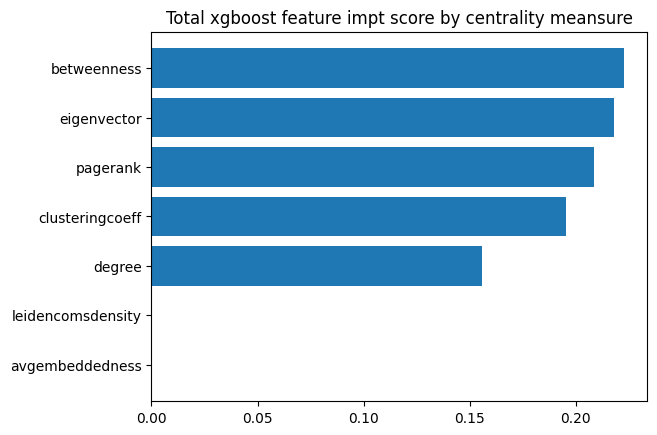

In [187]:
# 15.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs
Derive featuresdirectly from graph files

### Read graph files from gdrive

In [188]:
# 15.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [189]:
# 15.1 Path where .gml files are placed:

pathToFolder = Path(graphfolder)
filelist = sorted(list(pathToFolder.iterdir()))
filelist[:5]   # a_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/b_bigraph_b_p_c.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/b_bigraph_b_p_d.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/b_bigraph_b_p_e.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/b_bigraph_b_p_f.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeclassification/models/b_bigraph_b_p_g.gml')]

### Read data files from gdrive:

In [195]:
# 16.0
orig_test = pd.read_pickle(datafolder / "orig_test.pkl")
orig_train = pd.read_pickle(datafolder / "orig_train.pkl")
train_binned = pd.read_pickle(datafolder / "train_binned.pkl")
test_binned = pd.read_pickle(datafolder / "test_binned.pkl")
train_trans = pd.read_pickle(datafolder / "train_trans.pkl")
test_trans = pd.read_pickle(datafolder / "test_trans.pkl")
cat_cols = ['b', 'c', 'e', 'g', 'i']
ct = utils.restorePythonObject("transformer.pkl", datafolder)

In [196]:
# 16.1 check data files:
#      All have 'target' col
orig_train.head(2)  # No target col
orig_test.head(2)   # NO target col
train_binned.head(2)
test_binned.head(2)
train_trans.head(2) # No target col
test_trans.head(2)  # No target col

,b,c,e,g,i
7725,-14.315200,74.589899,0.466048,37.919595,-44.299018
6140,-80.635227,-56.720549,-76.390224,34.993668,-58.510573


,b,c,e,g,i
1639,62.383932,-60.520400,-48.426510,-109.794583,42.439040
16329,-17.246265,-18.384437,28.054278,0.101419,26.290043


,b,c,e,g,i,target
7725,441,868,1250,1659,2038,0
6140,427,835,1232,1658,2034,0


,b,c,e,g,i,target
1639,458,834,1239,1619,2064,1
16329,441,845,1257,1649,2059,1


,b,c,e,g,i,deg_b_ck_c,eig_b_ck_c,pr_b_ck_c,clu_b_ck_c,bet_b_ck_c,...,deg_i_ck_c_p_g,eig_i_ck_c_p_g,pr_i_ck_c_p_g,clu_i_ck_c_p_g,bet_i_ck_c_p_g,deg_i_ck_e_p_g,eig_i_ck_e_p_g,pr_i_ck_e_p_g,clu_i_ck_e_p_g,bet_i_ck_e_p_g
0,441,868,1250,1659,2038,1.0,0.110354,0.011601,0.927228,0.001214,...,0.645161,0.137524,0.015967,0.814689,0.005758,0.580645,0.146597,0.016932,0.703005,0.023241
1,427,835,1232,1658,2034,1.0,0.110354,0.011601,0.927228,0.001214,...,0.591398,0.128903,0.014712,0.856566,0.003189,0.559140,0.140896,0.015771,0.719457,0.010659


,b,c,e,g,i,deg_b_ck_c,eig_b_ck_c,pr_b_ck_c,clu_b_ck_c,bet_b_ck_c,...,deg_i_ck_c_p_g,eig_i_ck_c_p_g,pr_i_ck_c_p_g,clu_i_ck_c_p_g,bet_i_ck_c_p_g,deg_i_ck_e_p_g,eig_i_ck_e_p_g,pr_i_ck_e_p_g,clu_i_ck_e_p_g,bet_i_ck_e_p_g
0,458,834,1239,1619,2064,1.0,0.110354,0.011601,0.927228,0.001214,...,0.623656,0.137951,0.015281,0.874168,0.002228,0.440860,0.116647,0.012736,0.843902,0.002904
1,441,845,1257,1649,2059,1.0,0.110354,0.011601,0.927228,0.001214,...,0.623656,0.137951,0.015281,0.874168,0.002228,0.494624,0.131913,0.014080,0.808696,0.005789


### Display graphs

In [197]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'b_projected' in str(i)]

bigraph = [str(i).split("/")[-1] for i in filelist if 'b_bigraph' in str(i)]
sb = sorted(bigraph, key=len)
sb[:5]   # bigraph files
print("\n\n====\n")
sp = sorted(projected, key=len)
sp[:5]    # projected graph files

['b_bigraph_c.gml',
 'b_bigraph_d.gml',
 'b_bigraph_e.gml',
 'b_bigraph_f.gml',
 'b_bigraph_g.gml']



====



['b_projected_c.gml',
 'b_projected_d.gml',
 'b_projected_e.gml',
 'b_projected_f.gml',
 'b_projected_g.gml']

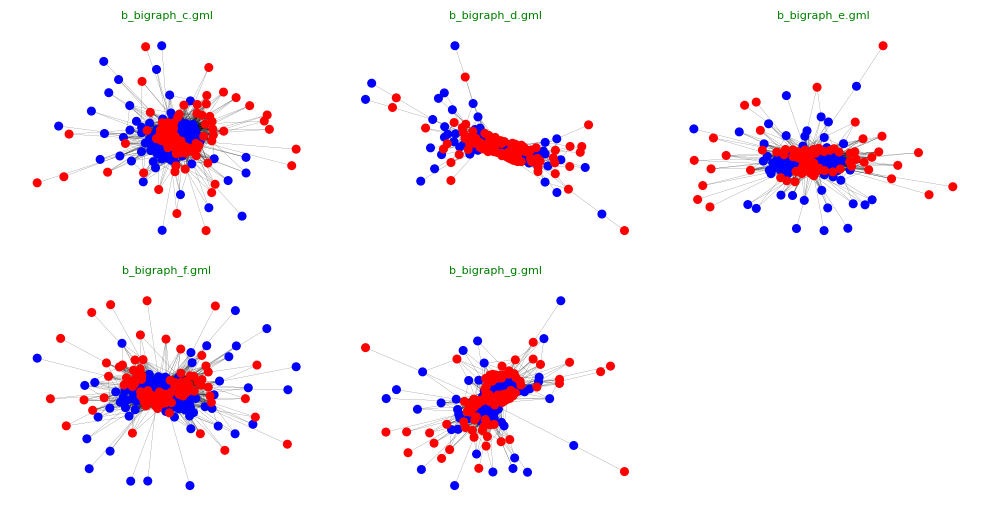

In [198]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for i in sb[:5]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=utils.plotBipartiteGraph(i,pathToFolder, ax = ax, title = i, connected = True);
    plt.tight_layout();

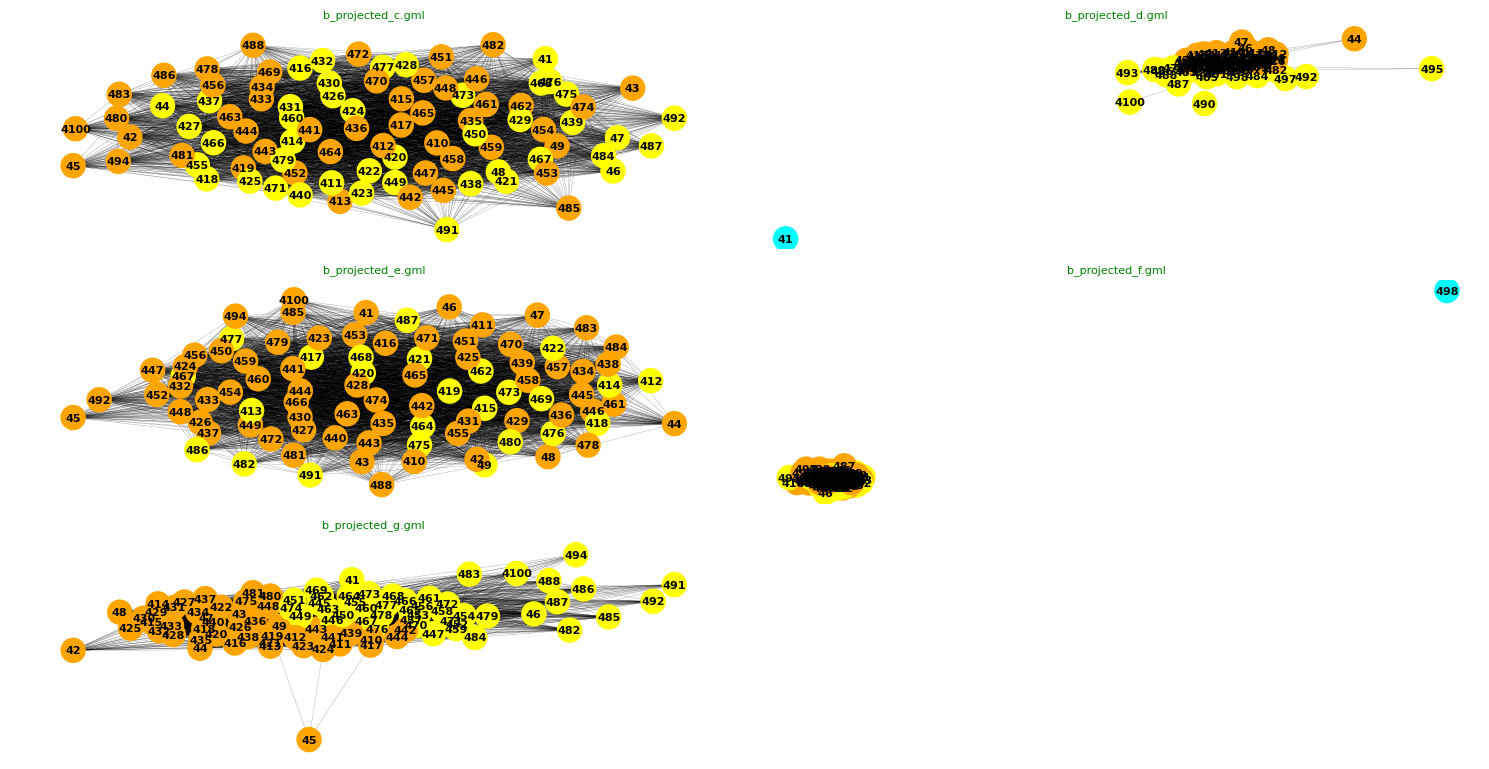

In [199]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for i in sp[:5]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=utils.communityVisualization(i,pathToFolder, ax = ax, withLabels = True, title = i);
    plt.tight_layout();

## Transform binned data to communities:

In [200]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binnedd cols are:
columnNames = best_features

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
#pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(best_features,graphfolder,train_binned,algo)
  _,df_te = utils.transformBinnedDF2Communities(best_features,graphfolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

Reading file:  b_projected_c.gml
Reading file:  b_projected_e.gml
Reading file:  b_projected_g.gml
Reading file:  b_projected_i.gml
Reading file:  c_projected_b.gml
Reading file:  c_projected_e.gml
Reading file:  c_projected_g.gml
Reading file:  c_projected_i.gml
Reading file:  e_projected_b.gml
Reading file:  e_projected_c.gml
Reading file:  e_projected_g.gml
Reading file:  e_projected_i.gml
Reading file:  g_projected_b.gml
Reading file:  g_projected_c.gml
Reading file:  g_projected_e.gml
Reading file:  g_projected_i.gml
Reading file:  i_projected_b.gml
Reading file:  i_projected_c.gml
Reading file:  i_projected_e.gml
Reading file:  i_projected_g.gml
Reading file:  b_projected_c.gml
Reading file:  b_projected_e.gml
Reading file:  b_projected_g.gml
Reading file:  b_projected_i.gml
Reading file:  c_projected_b.gml
Reading file:  c_projected_e.gml
Reading file:  c_projected_g.gml
Reading file:  c_projected_i.gml
Reading file:  e_projected_b.gml
Reading file:  e_projected_c.gml
Reading fi

In [201]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].head(3)
fg_te[0].head(3)

,b_projected_c.gml,b_projected_e.gml,b_projected_g.gml,b_projected_i.gml,c_projected_b.gml,c_projected_e.gml,c_projected_g.gml,c_projected_i.gml,e_projected_b.gml,e_projected_c.gml,e_projected_g.gml,e_projected_i.gml,g_projected_b.gml,g_projected_c.gml,g_projected_e.gml,g_projected_i.gml,i_projected_b.gml,i_projected_c.gml,i_projected_e.gml,i_projected_g.gml
7725,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0
6140,1,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0
11918,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1


,b_projected_c.gml,b_projected_e.gml,b_projected_g.gml,b_projected_i.gml,c_projected_b.gml,c_projected_e.gml,c_projected_g.gml,c_projected_i.gml,e_projected_b.gml,e_projected_c.gml,e_projected_g.gml,e_projected_i.gml,g_projected_b.gml,g_projected_c.gml,g_projected_e.gml,g_projected_i.gml,i_projected_b.gml,i_projected_c.gml,i_projected_e.gml,i_projected_g.gml
1639,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
16329,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2770,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [202]:
# 18.6 Extract target columns:

ytr = y_train = train_binned['target']
yte = y_test = test_binned['target']

### xgboost modeling of community data:

In [203]:
# 19.0 Modeling with community train/test data features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 200,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 800,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[06:52:34] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:52:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 774 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.94218	validation_1-auc:0.91382
[06:52:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 720 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.94607	validation_1-auc:0.91972
[06:52:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 730 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.94757	validation_1-auc:0.92046
[06:52:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 798 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.94915	validation_1-auc:0.92216
[06:52:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 770 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.95033	validation_1-auc:0.92346
[06:52:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 820 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

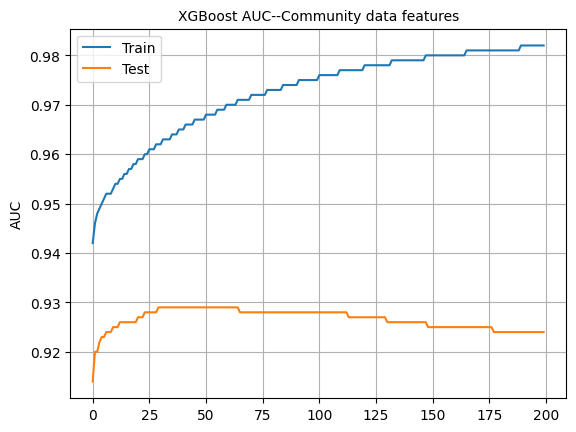

In [205]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid()
plt.ylabel('AUC');
plt.title('XGBoost AUC--Community data features', fontsize = 10);
plt.show();

### PCA of community data:

In [206]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,b_projected_c.gml,b_projected_e.gml,b_projected_g.gml,b_projected_i.gml,c_projected_b.gml,c_projected_e.gml,c_projected_g.gml,c_projected_i.gml,e_projected_b.gml,e_projected_c.gml,e_projected_g.gml,e_projected_i.gml,g_projected_b.gml,g_projected_c.gml,g_projected_e.gml,g_projected_i.gml,i_projected_b.gml,i_projected_c.gml,i_projected_e.gml,i_projected_g.gml
7725,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0
6140,1,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0
11918,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1


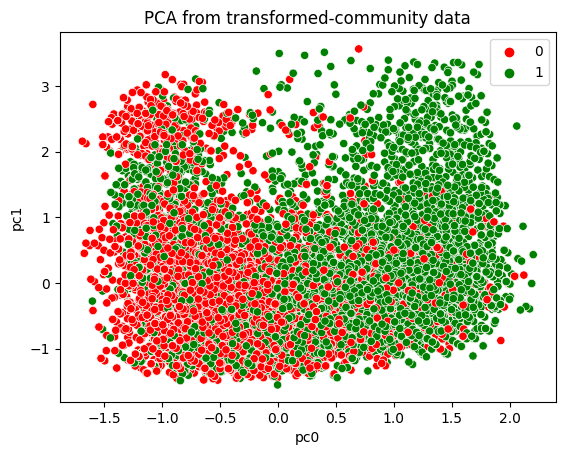

In [208]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("default")
sns.scatterplot(data = commu_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
##*****************************

### REad data

In [211]:
# 21.1.1
test_binned = pd.read_pickle(datafolder / "test_binned.pkl")
test_trans = pd.read_pickle(datafolder / "test_trans.pkl")

# 21.1.2
train_binned = pd.read_pickle(datafolder / "train_binned.pkl")
train_trans = pd.read_pickle(datafolder / "train_trans.pkl")

# 21.1.3
orig_test = pd.read_pickle(datafolder / "orig_test.pkl")
orig_train = pd.read_pickle(datafolder / "orig_train.pkl")

# 21.1.4
cat_cols =  ['b','c','e','g', 'i']

# 21.1.5
y_train = train_binned['target'].reset_index(drop=True)
y_test = test_binned['target'].reset_index(drop = True)

# 21.1.6
ct = utils.restorePythonObject("transformer.pkl", datafolder)

# 21.1.7
train_trans= pd.read_pickle(datafolder / "train_trans.pkl")

In [212]:
# 21.2 Check for nulls:
train_trans.isnull().sum().sum()  # 0
print("---")
test_trans.isnull().sum().sum()   # 432

0

---


432

In [213]:
# 21.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [214]:
'target' in list(train_trans.columns)
'target' in list(test_trans.columns)

False

False

In [217]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [218]:
# 22.0 Derive unit vectors:

p = Path(unitvecfolder)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 22.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = unitvecfolder,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for b
Checked for c
Checked for e
Checked for g
Checked for i
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/makeclassification/unitvecfolder'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for b
Checked for c
Checked for e
Checked for g
Checked for i


## Save unit-vectors files to gdrive
Also save output dictionaries for later use

In [219]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", unitvecfolder)
utils.savePythonObject(vec_te, "vec_te.pkl",unitvecfolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/makeclassification/unitvecfolder/vec_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/makeclassification/unitvecfolder/vec_te.pkl


## Restore unit-vectors files from gdrive

In [220]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", unitvecfolder)
vec_te = utils.restorePythonObject("vec_te.pkl",unitvecfolder)

## Using unit vectors to transform train/test data

In [221]:
# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for b for train data
Performing PCA for b for test data
Performing PCA for c for train data
Performing PCA for c for test data
Performing PCA for e for train data
Performing PCA for e for test data
Performing PCA for g for train data
Performing PCA for g for test data
Performing PCA for i for train data
Performing PCA for i for test data
Concatenating train data
Concatenating test data
Done......


In [222]:
# 23.1

cctr.head(3)
ccte.head(3)

,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,pcc2,pcc3,pce0,pce1,pce2,pce3,pcg0,pcg1,pcg2,pcg3,pci0,pci1,pci2,pci3
0,-3.114078,-0.370083,1.084302,-0.034976,-1.383307,-3.344333,0.469203,-1.417310,-4.036601,-0.686368,-0.901666,3.490931,-0.465979,-3.440899,-0.178519,0.378183,-2.356087,0.824734,-1.627134,0.773803
1,1.488746,-3.686854,-1.350687,0.637257,4.947098,0.762304,-2.673703,0.249779,2.960733,-2.860963,1.261159,-0.767328,-0.233888,-0.649981,0.608194,0.847389,1.375086,-1.657434,-1.769961,0.393090
2,-6.067633,4.330190,3.439493,-1.977815,42.815628,-1.361127,5.759257,4.848915,1.267482,-0.164148,-1.627056,1.191922,-3.243013,3.084709,-0.298625,-0.025759,-0.965846,-0.093055,0.123522,0.239881


,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,pcc2,pcc3,pce0,pce1,pce2,pce3,pcg0,pcg1,pcg2,pcg3,pci0,pci1,pci2,pci3
0,-3.464275,4.078524,0.367824,-1.315075,4.008007,-1.049746,-2.565284,1.588765,-2.334465,-1.720565,0.225299,1.269616,18.299655,2.654999,2.172596,-2.070741,0.271737,-2.541301,0.522605,-0.625221
1,-3.114069,-0.370083,1.084356,-0.034856,1.274800,3.246644,-0.330216,-1.727079,-1.742508,0.621956,0.141344,-0.193394,-2.927484,-1.236332,0.765244,-0.032806,-0.213208,-0.904091,1.232385,-1.372585
2,11.313794,2.568682,-4.102739,-2.342598,-1.258648,-1.218396,-0.714353,1.871761,-3.082762,2.413980,-0.353404,-0.464271,-1.393890,1.940784,-0.063484,-1.404519,-1.560063,1.570154,1.528177,-0.575839


In [223]:
# 23.2

cctr.shape   #  (18000,20)
ccte.shape   #  (2000,20)

(18000, 20)

(2000, 20)

In [225]:
# 23.3

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:]))


['pcb0', 'pcb1', 'pcb2', 'pcb3', 'pcc0', 'pcc1', 'pcc2', 'pcc3', 'pce0', 'pce1']
['pce2', 'pce3', 'pcg0', 'pcg1', 'pcg2', 'pcg3', 'pci0', 'pci1', 'pci2', 'pci3']


### Save unitvectors transformed train/test

In [226]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(datafolder / "cctr.pkl")
ccte.to_pickle(datafolder / "ccte.pkl")

### Readback unitvectors transformed train/test

In [227]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(datafolder / "cctr.pkl")
ccte = pd.read_pickle(datafolder / "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (513,20)
ccte.shape # (56,20)

,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,pcc2,pcc3,pce0,pce1,pce2,pce3,pcg0,pcg1,pcg2,pcg3,pci0,pci1,pci2,pci3
0,-3.114078,-0.370083,1.084302,-0.034976,-1.383307,-3.344333,0.469203,-1.417310,-4.036601,-0.686368,-0.901666,3.490931,-0.465979,-3.440899,-0.178519,0.378183,-2.356087,0.824734,-1.627134,0.773803
1,1.488746,-3.686854,-1.350687,0.637257,4.947098,0.762304,-2.673703,0.249779,2.960733,-2.860963,1.261159,-0.767328,-0.233888,-0.649981,0.608194,0.847389,1.375086,-1.657434,-1.769961,0.393090


,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,pcc2,pcc3,pce0,pce1,pce2,pce3,pcg0,pcg1,pcg2,pcg3,pci0,pci1,pci2,pci3
0,-3.464275,4.078524,0.367824,-1.315075,4.008007,-1.049746,-2.565284,1.588765,-2.334465,-1.720565,0.225299,1.269616,18.299655,2.654999,2.172596,-2.070741,0.271737,-2.541301,0.522605,-0.625221
1,-3.114069,-0.370083,1.084356,-0.034856,1.274800,3.246644,-0.330216,-1.727079,-1.742508,0.621956,0.141344,-0.193394,-2.927484,-1.236332,0.765244,-0.032806,-0.213208,-0.904091,1.232385,-1.372585


(18000, 20)

(2000, 20)

## xgboost modeling

In [228]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[08:47:52] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[08:47:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 696 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.97697	validation_1-auc:0.96289
[08:47:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 642 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.98111	validation_1-auc:0.96656
[08:47:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.98435	validation_1-auc:0.96832
[08:47:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 672 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.98529	validation_1-auc:0.97027
[08:47:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 744 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.98700	validation_1-auc:0.97161
[08:47:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 704 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [229]:
# 24.2 Best scores:

model_vec.best_score   # 0.9806576
print("\n")
model_vec.best_iteration  # 159


0.9806576595768088

159

In [231]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1011
           1       0.94      0.94      0.94       989

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



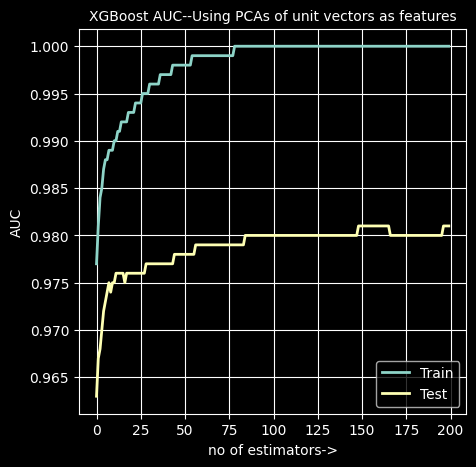

In [232]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);


## Feature Engineering with clustering

In [238]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 6,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16


In [239]:
# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,pcc2,pcc3,pce0,pce1,...,pcg3,pci0,pci1,pci2,pci3,clu0,clu1,clu2,clu3,clu4
0,-3.114078,-0.370083,1.084302,-0.034976,-1.383307,-3.344333,0.469203,-1.417310,-4.036601,-0.686368,...,0.378183,-2.356087,0.824734,-1.627134,0.773803,4,4,0,2,5
1,1.488746,-3.686854,-1.350687,0.637257,4.947098,0.762304,-2.673703,0.249779,2.960733,-2.860963,...,0.847389,1.375086,-1.657434,-1.769961,0.393090,1,1,1,2,2
2,-6.067633,4.330190,3.439493,-1.977815,42.815628,-1.361127,5.759257,4.848915,1.267482,-0.164148,...,-0.025759,-0.965846,-0.093055,0.123522,0.239881,0,5,1,1,0


,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,pcc2,pcc3,pce0,pce1,...,pcg3,pci0,pci1,pci2,pci3,clu0,clu1,clu2,clu3,clu4
0,-3.464275,4.078524,0.367824,-1.315075,4.008007,-1.049746,-2.565284,1.588765,-2.334465,-1.720565,...,-2.070741,0.271737,-2.541301,0.522605,-0.625221,0,1,0,0,2
1,-3.114069,-0.370083,1.084356,-0.034856,1.274800,3.246644,-0.330216,-1.727079,-1.742508,0.621956,...,-0.032806,-0.213208,-0.904091,1.232385,-1.372585,4,0,4,2,0
2,11.313794,2.568682,-4.102739,-2.342598,-1.258648,-1.218396,-0.714353,1.871761,-3.082762,2.413980,...,-1.404519,-1.560063,1.570154,1.528177,-0.575839,5,2,4,1,0


In [240]:
# 25.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()


,clu0,clu1,clu2,clu3,clu4
0,4,4,0,2,5
1,1,1,1,2,2
2,0,5,1,1,0
3,1,2,4,2,5
4,1,4,1,0,2


,clu0,clu1,clu2,clu3,clu4
0,0,1,0,0,2
1,4,0,4,2,0
2,5,2,4,1,0
3,0,0,4,1,2
4,1,0,4,2,5


In [241]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[08:52:46] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[08:52:46] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.93873	validation_1-auc:0.92859
[08:52:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.93935	validation_1-auc:0.92938
[08:52:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.93966	validation_1-auc:0.93015
[08:52:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.94008	validation_1-auc:0.93102
[08:52:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.94126	validation_1-auc:0.93235
[08:52:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [242]:
model_fe.best_score  # 0.936791351


0.9367913517535622

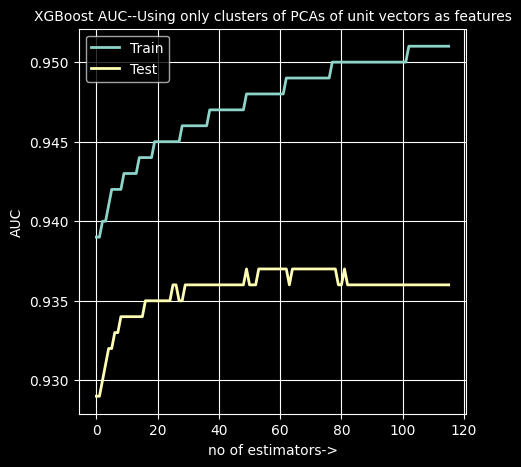

In [243]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);


## Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [244]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for b
Checked for c
Checked for e
Checked for g
Checked for i
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/makeclassification/unitvecfolder'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
############# DONE ###################